# Airline fare price prediction

Using the dataset provided by [lalit_joshi](https://www.kaggle.com/datasets/lalitjoshi89/airlinepriceprediction)

In [2]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import unicodedata

In [3]:
# Loading "raw" data from csv for a quick glance
data = pd.read_csv(r'dataset/airlines_data.csv')
data.info

<bound method DataFrame.info of      ;Airline_Name;Date_of_Journey;Source;Destination;Dept_Time;Total_Stops;Duration_of_Flight;Arr_Time;Fare
0     0;AirAsia;26/02/2022;Kolkata;Mumbai;13:30;1 st...                                                     
1     1;AirAsia;26/02/2022;Kolkata;Mumbai;9:05;2 sto...                                                     
2     2;AirAsia;26/02/2022;Kolkata;Mumbai;16:15;1 st...                                                     
3     3;AirAsia;26/02/2022;Kolkata;Mumbai;23:40;1 st...                                                     
4     4;AirAsia;26/02/2022;Kolkata;Mumbai;20:00;1 st...                                                     
...                                                 ...                                                     
2016  2019;Vistara;10/7/22;Mumbai;Chennai;6:20;2 Sto...                                                     
2017  2020;Vistara;10/7/22;Mumbai;Chennai;11:25;2 St...                                         

### The Dataset

The data comes in a excel file format which I re-exported as a csv directly from Excel (note this could have been done using python too.)

In the data we have 10 variables and 2021 features. But we get all in 1 column due to the file being delimeted by semicolon. Lets fix that!

In [4]:
# Loading the data  with necessary attribute to convert it correctly into a dataframe
data = pd.read_csv(r'dataset/airlines_data.csv', delimiter=';', thousands=' ')
data

,Unnamed: 0,Airline_Name,Date_of_Journey,Source,Destination,Dept_Time,Total_Stops,Duration_of_Flight,Arr_Time,Fare
0,0,AirAsia,26/02/2022,Kolkata,Mumbai,13:30,1 stop,07 h 05 m,20:35,3 379
1,1,AirAsia,26/02/2022,Kolkata,Mumbai,9:05,2 stop,13 h 10 m,22:15,3 379
2,2,AirAsia,26/02/2022,Kolkata,Mumbai,16:15,1 stop,08 h 20 m,0:35,3 379
3,3,AirAsia,26/02/2022,Kolkata,Mumbai,23:40,1 stop,06 h 55 m,6:35,3 379
4,4,AirAsia,26/02/2022,Kolkata,Mumbai,20:00,1 stop,10 h 35 m,6:35,3 379
...,...,...,...,...,...,...,...,...,...,...
2016,2019,Vistara,10/7/22,Mumbai,Chennai,6:20,2 Stop,13h 55m,20:15,15 192
2017,2020,Vistara,10/7/22,Mumbai,Chennai,11:25,2 Stop,11h 20m,22:45,16 442
2018,2021,Vistara,10/7/22,Mumbai,Chennai,6:45,2 Stop,13h 30m,20:15,16 442
2019,2022,Vistara,10/7/22,Mumbai,Chennai,9:05,2 Stop,11h 10m,20:15,17 282


In [5]:
# Observing data types
data.dtypes

Unnamed: 0             int64
Airline_Name          object
Date_of_Journey       object
Source                object
Destination           object
Dept_Time             object
Total_Stops           object
Duration_of_Flight    object
Arr_Time              object
Fare                  object
dtype: object

In [6]:
# Checking for missing values
data.isnull().sum()

Unnamed: 0            0
Airline_Name          0
Date_of_Journey       0
Source                0
Destination           0
Dept_Time             0
Total_Stops           0
Duration_of_Flight    0
Arr_Time              0
Fare                  0
dtype: int64

### **Good!** and **Bad!**

Now there are some obvious observations that need to be address such as:

- The first `Unnamed` feature is redundant  and needs to be impute as it seems index.
- There is inconsistenacy on the date format on the `Date_of_Journey` feature
- The `Total_Stops` feature should be converted to numerical values.

A lot of our data is not the proper type such as:
- `Date_of_Journey` should be `datetime`
- `Dept_Time`, `Arr_time`, `Duration_of_Flight` should be `datetime` or `timedelta`
- `Total_Stops` should be `int`
- `Fare` should be `int`

It would be a good idea to change the name of the features to shorter names.

I found that `Airline_Name`, `Source` and `Destination` have repeated or diferent instances of the same word and that needs to be change i.e.: "Air Asia" instead of "AirAsia" or "MAA" instead of Chennai.

In [7]:
# Imputing the  "Unnamed" feature
data.drop(data.columns[0], axis=1, inplace=True)

In [8]:
# Renaming and reordering features.
new_cols = ["airline_name", "flight_date", "flight_dep", "flight_arr", "dep_time", "total_stops", "flight_time", "arr_time", "flight_fare"]
data.columns = new_cols

new_cols_ord = ["airline_name", "flight_date", "flight_dep", "dep_time", "flight_arr", "arr_time", "total_stops","flight_time", "flight_fare"]
data = data.reindex(columns=new_cols_ord)

In [9]:
# Changing data type of flight_date to desire format: Y-M-D.
data['flight_date'] = pd.to_datetime(data['flight_date'])

In [10]:
# Changing dep_time and arr_time data type.

"""Each instance is a datetime object altought is not shown when data.dtypes is executed"""

data['dep_time'] = pd.to_datetime(data.dep_time, format='%H:%M').dt.time
data['arr_time'] = pd.to_datetime(data.arr_time, format='%H:%M').dt.time



In [11]:
# Converting string to numerical values in total_flights feature.

"""numpy.where, is a vectorized version of if/else, with the 
condition constructed by str.contains"""

data['total_stops'] = np.where(data.total_stops.str.contains("1"), 1,
                    np.where(data.total_stops.str.contains("2"), 2, 
                    np.where(data.total_stops.str.contains("3"), 3, 0,
                    )
                )
            )    

In [12]:
# Converting flight_time to timedelta type.
data['flight_time'] = pd.to_timedelta(data['flight_time'])

In [13]:
# Changing "flight_fare" to int data type

"""The feature came with a unicode break '\xa0' the unicodedata.normalize() will remove this issue"""

data['flight_fare'] = data['flight_fare'].apply(lambda x: unicodedata.normalize("NFKD", x).replace(' ',''));
data['flight_fare'] = pd.to_numeric(data['flight_fare']);


In [14]:
# Removing repeated values on 'airline_name' feature
airline_values = {
    'Air Asia':'AirAsia',
    'Spicejet':'SpiceJet'
}

for key, value in airline_values.items():
    # Replace key character with value character in string
    data['airline_name'] = data['airline_name'].replace(key, value)

In [15]:
# Removing repeated values on 'flight_dep' feature
dest_values = {'DEL':'New Delhi', 'GAU': 'Guwahati',
                'MAA': 'Chennai', 'BLR':'Bangalore',
                'CCU':'Kolkata', 'BOM':'Mumbai',
                'Bengaluru':'Bangalore'}

for key, value in dest_values.items():
    # Replace key character with value character in string
    data['flight_dep'] = data['flight_dep'].replace(key, value)

In [16]:
# Removing repeated values on 'flight_dep' feature
for key, value in dest_values.items():
    # Replace key character with value character in string
    data['flight_arr'] = data['flight_arr'].replace(key, value)

In [17]:
data

,airline_name,flight_date,flight_dep,dep_time,flight_arr,arr_time,total_stops,flight_time,flight_fare
0,AirAsia,2022-02-26,Kolkata,13:30:00,Mumbai,20:35:00,1,0 days 07:05:00,3379
1,AirAsia,2022-02-26,Kolkata,09:05:00,Mumbai,22:15:00,2,0 days 13:10:00,3379
2,AirAsia,2022-02-26,Kolkata,16:15:00,Mumbai,00:35:00,1,0 days 08:20:00,3379
3,AirAsia,2022-02-26,Kolkata,23:40:00,Mumbai,06:35:00,1,0 days 06:55:00,3379
4,AirAsia,2022-02-26,Kolkata,20:00:00,Mumbai,06:35:00,1,0 days 10:35:00,3379
...,...,...,...,...,...,...,...,...,...
2016,Vistara,2022-10-07,Mumbai,06:20:00,Chennai,20:15:00,2,0 days 13:55:00,15192
2017,Vistara,2022-10-07,Mumbai,11:25:00,Chennai,22:45:00,2,0 days 11:20:00,16442
2018,Vistara,2022-10-07,Mumbai,06:45:00,Chennai,20:15:00,2,0 days 13:30:00,16442
2019,Vistara,2022-10-07,Mumbai,09:05:00,Chennai,20:15:00,2,0 days 11:10:00,17282


In [18]:
data.dtypes

airline_name             object
flight_date      datetime64[ns]
flight_dep               object
dep_time                 object
flight_arr               object
arr_time                 object
total_stops               int64
flight_time     timedelta64[ns]
flight_fare               int64
dtype: object

In [19]:
unique_vals = data['airline_name'].unique()
print(f"There are {len(unique_vals)} unique elements in this feature : {unique_vals} ")

There are 6 unique elements in column : ['AirAsia' 'Go First' 'SpiceJet' 'IndiGo' 'Air India' 'Vistara'] 


### It's Exploratory Data Analaysis o'clock

- Highest and lowest fare (More expensive or cheapest airline to flight with)
- Longest and shortest flight
- Cheapest

In [23]:
data.describe()

,total_stops,flight_time,flight_fare
count,2021.000000,2021,2021.000000
mean,0.794656,0 days 08:24:19.030183077,4511.821870
std,0.564539,0 days 06:27:42.884939161,2073.431268
min,0.000000,0 days 01:35:00,1841.000000
25%,0.000000,0 days 02:50:00,3100.000000
50%,1.000000,0 days 07:00:00,4147.000000
75%,1.000000,0 days 10:50:00,5335.000000
max,3.000000,1 days 16:25:00,17282.000000


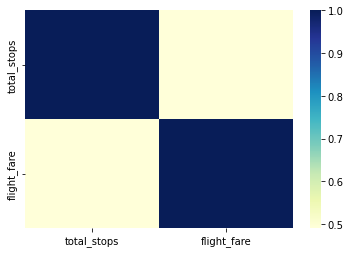

In [20]:
sns.heatmap(data.corr(), cmap="YlGnBu")
plt.show()